# classic CNN for MNIST dataset

Building a very simple Convolutional Neural Network to classify handwritten digits 0-9

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# i don't have cuda lol
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [2]:
# load MNIST dataset

# turn it into a torch tensor, then normalize (input - mean / std)
transform = transforms.Compose(transforms=[
    transforms.ToTensor(), transforms.Normalize(mean=0.13007, std=0.3081)
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Training: {len(train_dataset)} samples, Test: {len(test_dataset)} samples')

Training: 60000 samples, Test: 10000 samples


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Feature extraction layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # Classification layers
        # After 2 pooling ops: 28x28 -> 14x14 -> 7x7, with 64 channels
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 digit classes
    
    def forward(self, x):
        # BATCH x 1 x 28 x 28
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # BATCH x 32 x 14 x 14
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # BATCH x 64 x 7 x 7

        # now, flatten tensor for the linear layers
        x = torch.flatten(x, start_dim=1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Test that the model structure is valid
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 5
train_losses = []

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # TODO(human): Implement the core training step
        # 
        # 4 essential steps:
        # 1. Zero the gradients (optimizer.zero_grad()) - why? gradients accumulate by default
        optimizer.zero_grad()

        # 2. Forward pass - get predictions from model
        outputs = model(images)

        # 3. Compute loss - compare predictions to labels using criterion
        loss = criterion(outputs, labels)

        # 4. Backward pass + update:
        loss.backward() # backprop / compute gradients
        optimizer.step() # updates weights
                
        running_loss += loss.item()
        
        # Print progress every 200 batches
        if batch_idx % 200 == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    # return average loss per batch
    return running_loss / len(train_loader)

In [5]:
# training loop
for i in range(1,EPOCHS+1):
    print(f"--- Epoch {i} ---")
    avg_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(avg_loss)
print(train_losses)

--- Epoch 1 ---
  Batch 0/938, Loss: 2.3041
  Batch 200/938, Loss: 0.0563
  Batch 400/938, Loss: 0.0157
  Batch 600/938, Loss: 0.0306
  Batch 800/938, Loss: 0.0470
--- Epoch 2 ---
  Batch 0/938, Loss: 0.0825
  Batch 200/938, Loss: 0.0292
  Batch 400/938, Loss: 0.0520
  Batch 600/938, Loss: 0.0868
  Batch 800/938, Loss: 0.0118
--- Epoch 3 ---
  Batch 0/938, Loss: 0.0662
  Batch 200/938, Loss: 0.0480
  Batch 400/938, Loss: 0.0025
  Batch 600/938, Loss: 0.0009
  Batch 800/938, Loss: 0.0849
--- Epoch 4 ---
  Batch 0/938, Loss: 0.0171
  Batch 200/938, Loss: 0.0068
  Batch 400/938, Loss: 0.0013
  Batch 600/938, Loss: 0.0008
  Batch 800/938, Loss: 0.0673
--- Epoch 5 ---
  Batch 0/938, Loss: 0.0090
  Batch 200/938, Loss: 0.0008
  Batch 400/938, Loss: 0.0344
  Batch 600/938, Loss: 0.0134
  Batch 800/938, Loss: 0.0008
--- Epoch 6 ---
  Batch 0/938, Loss: 0.0061
  Batch 200/938, Loss: 0.0041
  Batch 400/938, Loss: 0.0070
  Batch 600/938, Loss: 0.0005
  Batch 800/938, Loss: 0.0011
--- Epoch 7 ---


In [6]:
# Evaluate on test set
def evaluate(model, test_loader, device):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to track gradients for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)  # Get class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

test_accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 98.62%


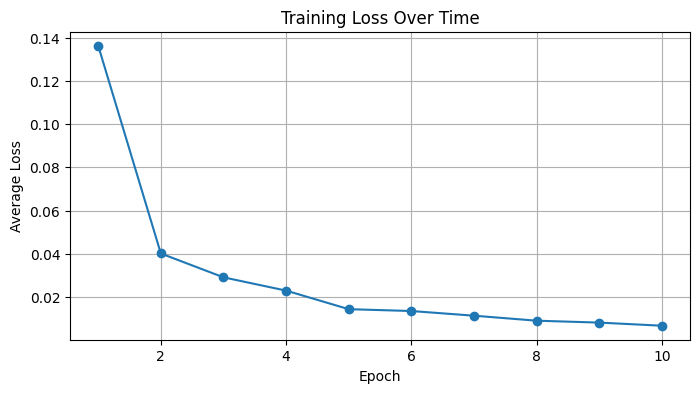

In [7]:
# Plot training loss curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

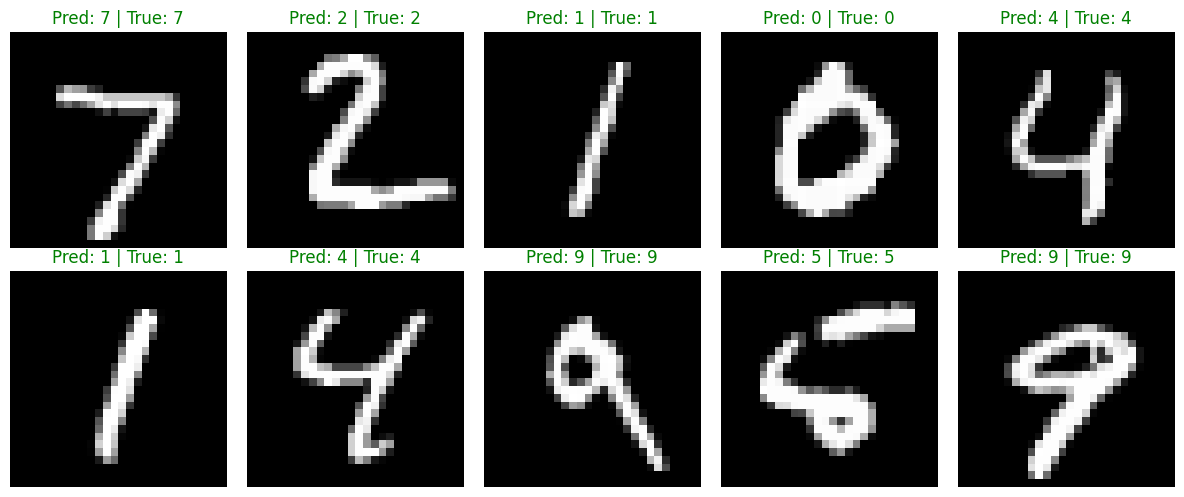

In [8]:
# Visualize predictions on sample test images
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        image, label = test_dataset[i]
        image_batch = image.unsqueeze(0).to(device)  # Add batch dimension
        
        output = model(image_batch)
        _, predicted = torch.max(output, dim=1)
        
        ax.imshow(image.squeeze(), cmap='gray')
        color = 'green' if predicted.item() == label else 'red'
        ax.set_title(f'Pred: {predicted.item()} | True: {label}', color=color)
        ax.axis('off')

plt.tight_layout()
plt.show()